In [1]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import scipy.stats
import cmocean

from plotting import plot_utils, summary_plots, load_fits
from utils import roi_utils, default_paths, prf_utils
from feature_extraction import gabor_feature_extractor


#### Load fit results

In [2]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'gabor_solo_ridge_12ori_8sf'
out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, \
                                  verbose=False) for ss in subjects]

# create non-overlapping ROIs
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

# make a list of voxels per subject
n_vox_each_subj = [out[si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)

# thresholding voxels based on their R2 for this model
r2_cutoff = 0.01
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

#### Get info about the Gabor feature space

In [3]:
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


#### Organize the feature selectivity matrices
feature selectivity = corr coef between model resp and feature channel activation

In [4]:
feature_corr = np.concatenate([out[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

# find maxes for orient/SF
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_corr[:,0:1], [1,n_ori])==mean_orient_corr, axis=1)
assert(not(np.any(is_constant)))

preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_corr[:,0:1], [1,n_sf])==mean_sf_corr, axis=1)
assert(not(np.any(is_constant)))


#### Plot distribution of preferred orientation
Merge voxels over all participants

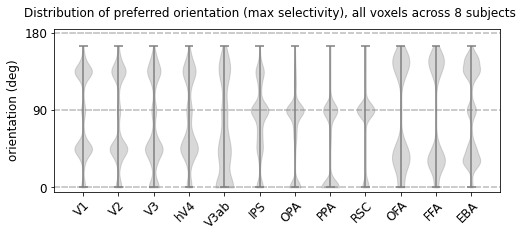

In [5]:
plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

color = '#7f7f7f'
    
plt.figure(figsize=(8,3))

for ri in range(n_rois):

    
    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    parts = plt.violinplot(ori_unique[preferred_ori_corr[inds_this_roi].astype(int)],[ri])
    for pc in parts['bodies']:
        pc.set_color(color)
    parts['cbars'].set_color(color)
    parts['cmins'].set_color(color)
    parts['cmaxes'].set_color(color)

    plt.yticks([0,90,180])
    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    plt.axhline(90,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    plt.axhline(180,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    
    plt.ylabel('orientation (deg)')
    plt.ylim([-5, 185])
    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

plt.xticks(ticks=np.arange(0,n_rois),labels=roi_names,\
                       rotation=45, ha='right',rotation_mode='anchor')

plt.suptitle('Distribution of preferred orientation (max selectivity), all voxels across 8 subjects')

fn2save = os.path.join(default_paths.fig_path,'Gabor_orient_violin.pdf')
plt.savefig(fn2save)

#### Plot distribution of preferred spatial frequency

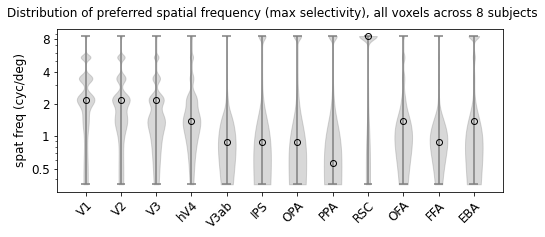

In [6]:

plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

color = '#7f7f7f'

plt.figure(figsize=(8,3))

for ri in range(n_rois):
    
    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    parts = plt.violinplot(sf_unique[preferred_sf_corr[inds_this_roi].astype(int)],[ri])
    for pc in parts['bodies']:
        pc.set_color(color)
    parts['cbars'].set_color(color)
    parts['cmins'].set_color(color)
    parts['cmaxes'].set_color(color)
    
    plt.plot(ri, np.median(sf_unique[preferred_sf_corr[inds_this_roi].astype(int)]),\
             marker='o',color='k', markerfacecolor='none')

    # plt.yticks([0,4,8])
    plt.gca().set_yscale('log')
    plt.yticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [0.5,1,2,4,8])
   
    plt.ylabel('spat freq (cyc/deg)')

    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

plt.xticks(ticks=np.arange(0,n_rois),labels=roi_names,\
                       rotation=45, ha='right',rotation_mode='anchor')

plt.suptitle('Distribution of preferred spatial frequency (max selectivity), all voxels across 8 subjects')

fn2save = os.path.join(default_paths.fig_path,'Gabor_spatfreq_violin.pdf')
plt.savefig(fn2save)

#### Now compute ROI-averaged response profiles
For each participant separately

In [7]:
avg_resp_profiles = np.zeros((n_subjects, n_rois, n_ori, n_sf))
for si in range(n_subjects):
    for ri in range(n_rois):        
        inds_this_roi = roi_def.get_indices(ri) & abv_thresh & (subject_inds==si)   
        avg_resp_profiles[si,ri,:,:] = np.mean(allcorr_reshaped[inds_this_roi,:,:], axis=0)

#### Plot average orientation selectivity profiles for each ROI

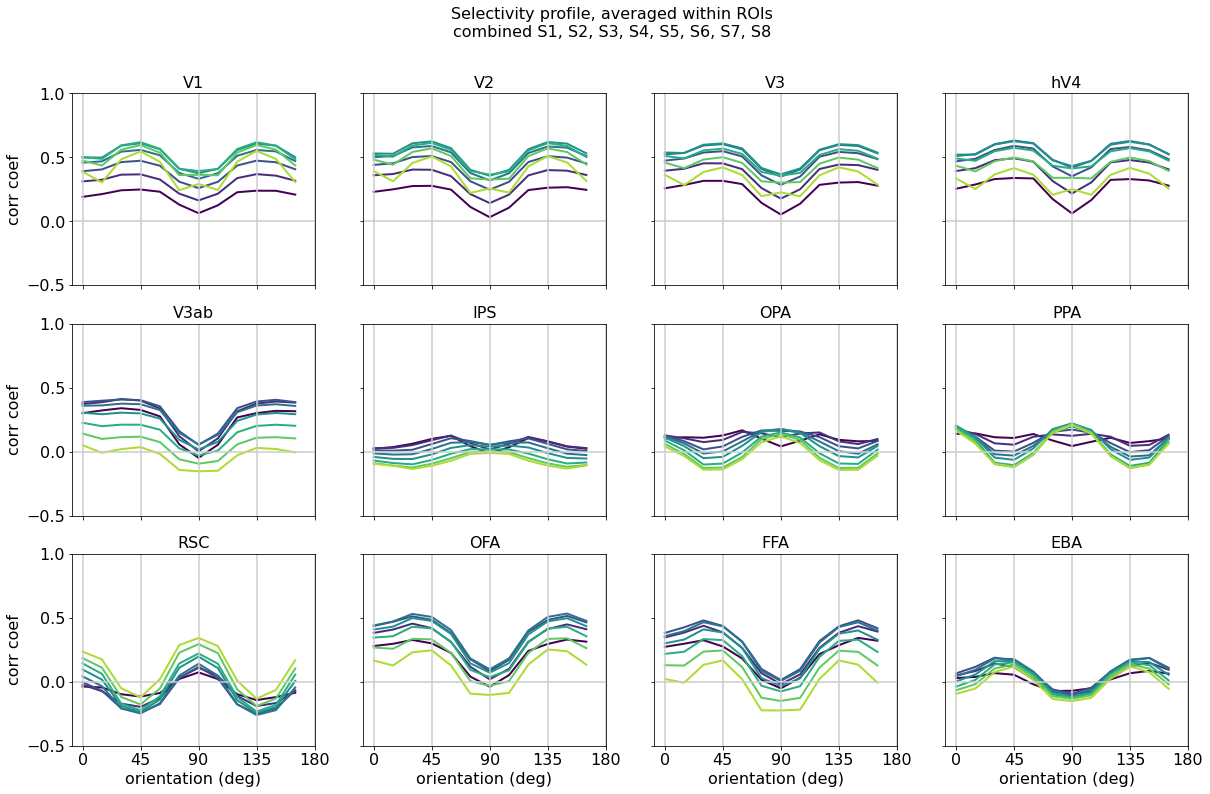

In [8]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

colors = cm.viridis(np.linspace(0,1,n_sf+1))[0:-1,:]

pi=0

for rr in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.mean(avg_resp_profiles[:,rr,:,:], axis=2)
    meanvals = np.mean(vals , axis=0)
   
    for sf in range(n_sf):
        vals = avg_resp_profiles[:,rr,:,sf]
        meanvals = np.mean(vals , axis=0)
       
        plt.plot(ori_unique,  meanvals, '-',color=colors[sf,:],linewidth=2)

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5,1])
    
    if np.mod(rr,4)==0:
        plt.ylabel('corr coef')
        plt.yticks(np.arange(-0.5, 1.2, 0.5))

    else:
        plt.yticks(np.arange(-0.5, 1.2, 0.5), labels=[])

    if pi>8:
        plt.xlabel('orientation (deg)')
        plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks(np.arange(0,181,45), labels=[])

    for ii in np.arange(0,181,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.title('%s'%(roi_names[rr]))

plt.suptitle('Selectivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out))

fn2save = os.path.join(default_paths.fig_path, 'Orient_selectivity_allareas.pdf')
plt.savefig(fn2save)

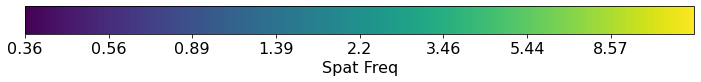

In [9]:
# make colorbar for spat freq color coding
import matplotlib

fig, ax = plt.subplots(figsize=(12, 1))
fig.subplots_adjust(bottom=0.5)

cmap = cm.viridis
norm = matplotlib.colors.Normalize(vmin=0, vmax=n_sf)

cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', \
                                ticks=np.arange(n_sf))
cb1.set_ticklabels(sf_unique.round(2))
# cb1.set_xlim([0, 8])
cb1.set_label('Spat Freq')
fig.show()

fn2save = os.path.join(default_paths.fig_path, 'Freq_colorbar.pdf')
plt.savefig(fn2save)

#### Plot average spatial frequency selectivity profiles for each ROI

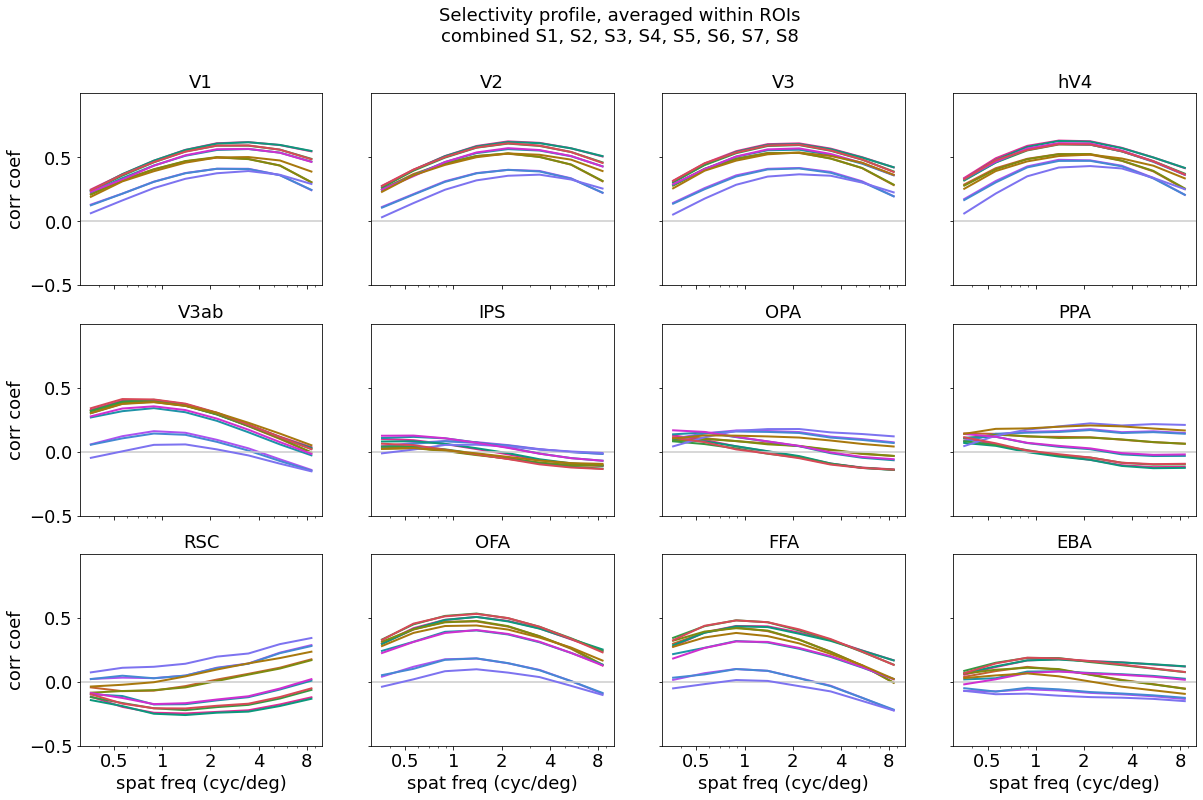

In [10]:
plot_utils.set_all_font_sizes(fs = 18)

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

colors = cmocean.cm.phase(np.linspace(0,1,n_ori+1))[0:-1,:]
# choose the order in which to layer the lines...some of them overlap almost completely, 
# so this makes it a little easier to see colors
zorders = np.arange(n_ori, 0, -1)
zorders[np.arange(1,12,2)]*=(-1)


pi=0
for rr in range(n_rois):
    
    vals = np.mean(avg_resp_profiles[:,rr,:,:], axis=1)
    meanvals = np.mean(vals , axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)
    
    pi+=1
    plt.subplot(npx,npy,pi)

    for oo in range(n_ori):
        vals = avg_resp_profiles[:,rr,oo,:]
        meanvals = np.mean(vals , axis=0)

        plt.plot(sf_unique,  meanvals, '-',color=colors[oo,:],linewidth=2, zorder=zorders[oo])
        
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5,1])

    if np.mod(pi,4)==1:
        plt.ylabel('corr coef')
        plt.yticks(np.arange(-0.5, 1, 0.5))
    else:
        plt.yticks(np.arange(-0.5, 1, 0.5), [])
    plt.gca().set_xscale('log')
    if pi>8:
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [0.5,1,2,4,8])
        plt.xlabel('spat freq (cyc/deg)')
    else:
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [])

    plt.title('%s'%(roi_names[rr]))

plt.suptitle('Selectivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out))

fn2save = os.path.join(default_paths.fig_path, 'Freq_selectivity_allareas.pdf')
plt.savefig(fn2save)


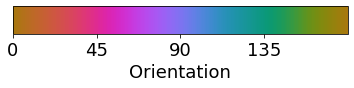

In [11]:
# make colorbar for orientation color coding
import matplotlib

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = cmocean.cm.phase
norm = matplotlib.colors.Normalize(vmin=0, vmax=180)

cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', \
                                ticks=[0, 45, 90, 135])
cb1.set_label('Orientation')
fig.show()

fn2save = os.path.join(default_paths.fig_path, 'Orient_colorbar.pdf')
plt.savefig(fn2save)

#### Plot selectivity profiles for a selected few areas

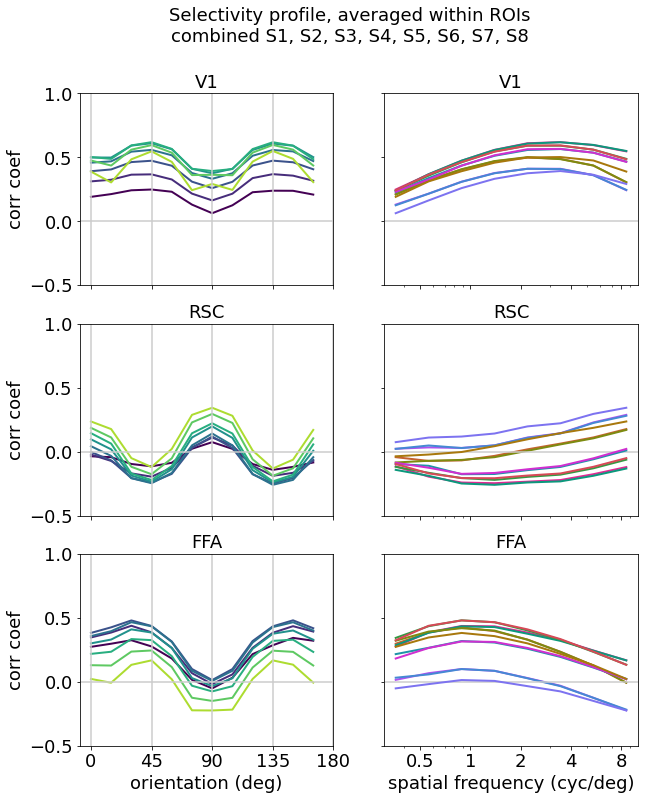

In [12]:
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(10,12))
npx = 3;
npy = 2;

sf_colors = cm.viridis(np.linspace(0,1,n_sf+1))[0:-1,:]

orient_colors = cmocean.cm.phase(np.linspace(0,1,n_ori+1))[0:-1,:]
# choose the order in which to layer the lines...some of them overlap almost completely, 
# so this makes it a little easier to see colors
zorders = np.arange(n_ori, 0, -1)
zorders[np.arange(1,12,2)]*=(-1)


pi=0
rois2plot = [0,8,10]
for rr in rois2plot:
# for rr in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)

    for sf in range(n_sf):
        vals = avg_resp_profiles[:,rr,:,sf]
        meanvals = np.mean(vals , axis=0)
        plt.plot(ori_unique,  meanvals, '-',color=sf_colors[sf,:],linewidth=2)
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5,1])
    
    if np.mod(pi,2):
        plt.ylabel('corr coef')
        plt.yticks(np.arange(-0.5, 1.2, 0.5))
    else:
        plt.yticks(np.arange(-0.5, 1.2, 0.5), labels=[])

    if pi>4:
        plt.xlabel('orientation (deg)')
        plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks(np.arange(0,181,45), labels=[])

    for ii in np.arange(0,181,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.title('%s'%(roi_names[rr]))
    
    pi+=1
    plt.subplot(npx,npy,pi)

    # choose the order in which to layer the lines...some of them overlap almost completely, 
    # so this makes it a little easier to see colors
    zorders = np.arange(n_ori, 0, -1)
    zorders[np.arange(1,12,2)]*=(-1)
    for oo in range(n_ori):
        vals = avg_resp_profiles[:,rr,oo,:]
        meanvals = np.mean(vals , axis=0)
        plt.plot(sf_unique,  meanvals, '-',color=orient_colors[oo,:],linewidth=2, \
                 zorder=zorders[oo])
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5,1])
    
    if np.mod(pi,2):
        plt.ylabel('corr coef')
        plt.yticks(np.arange(-0.5, 1.2, 0.5))
    else:
        plt.yticks(np.arange(-0.5, 1.2, 0.5), labels=[])

    plt.gca().set_xscale('log')
    if pi>4:
        plt.xlabel('spatial frequency (cyc/deg)')
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [0.5,1,2,4,8])
    
    else:
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [])

    plt.title('%s'%(roi_names[rr]))

plt.suptitle('Selectivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out))

fn2save = os.path.join(default_paths.fig_path, 'Gabor_profiles_selectedareas.pdf')
plt.savefig(fn2save)


#### Compute radial bias: first gather our pRF pars

In [13]:
prf_pars = np.concatenate([out[si]['best_params'][0][:,0,:] for si in range(n_subjects)], axis=0)
x = prf_pars[:,0]
y = prf_pars[:,1]

screen_eccen_deg = 8.4
angle_fwrf, eccen_fwrf = prf_utils.cart_to_pol(x*screen_eccen_deg,y*screen_eccen_deg)
sigma = prf_pars[:,2]
size_fwrf = sigma * screen_eccen_deg

#### Now make a plot of the correlation bw polar angle pref and orient pref

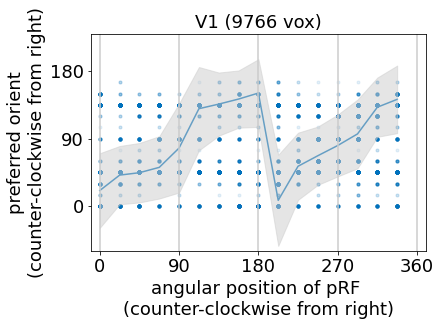

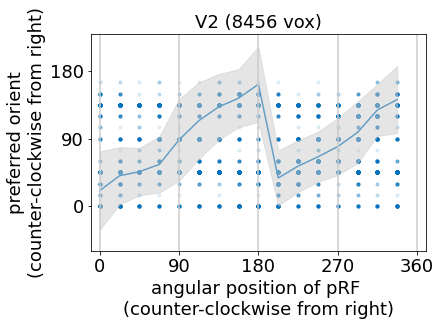

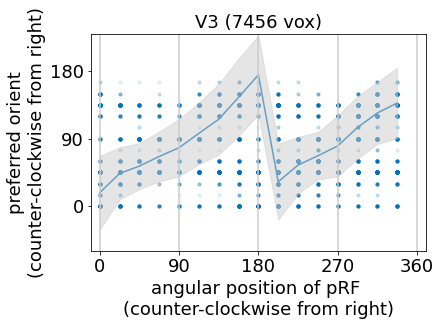

In [14]:
color = '#0071bc'
plt.rcParams['pdf.fonttype']=42

for vv in [0,1,2]:

    r2_cutoff = 0.01
    val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
    abv_thresh = val_r2>r2_cutoff

    vinds = roi_def.get_indices(vv) & abv_thresh

    plt.figure(figsize=(6,4))

    xvals = np.round(angle_fwrf[vinds],1)
    unique_angles, counts = np.unique(xvals, return_counts=True)

    # change the coordinate system of orientation here, so that it matches with 
    # the angular positions (go counter-clockwise from right)
    yvals = np.mod(90 - ori_unique[preferred_ori_corr[vinds].astype(int)], 180)  
    # yvals = np.mod(90 - ori_unique[preferred_ori_weights[vinds].astype(int)], 180)  
    yvals_adj = yvals/180*2*np.pi # for circmean/circstd, need range 0-2pi

    ymean = np.array([scipy.stats.circmean(yvals_adj[xvals==aa]) for aa in unique_angles])*180/(2*np.pi)
    ystd = np.array([scipy.stats.circstd(yvals_adj[xvals==aa]) for aa in unique_angles])*180/(2*np.pi)

    plt.plot(xvals, yvals,'.',color=color, alpha=0.10)

    # plt.errorbar(unique_angles, ymean, ystd, color='k',zorder=10)
    plt.plot(unique_angles, ymean,'-',color=color)
    plt.fill_between(unique_angles, ymean+ystd, ymean-ystd, color=[0.8, 0.8, 0.8] ,alpha=0.5, zorder=10)

    for ii in np.arange(0,370,90):
        plt.axvline(ii, color=[0.8, 0.8, 0.8])

    plt.xticks(np.arange(0,370,90));
    plt.yticks(np.arange(0,190,90));
    plt.xlabel('angular position of pRF \n(counter-clockwise from right)')
    plt.ylabel('preferred orient\n(counter-clockwise from right)')

    plt.xlim([-10, 370])
    plt.ylim([-60, 230])

    plt.title('%s (%d vox)'%(roi_names[vv],np.sum(vinds)))

    fn2save = os.path.join(default_paths.fig_path, '%s_radial_bias.pdf'%roi_names[vv])
    plt.savefig(fn2save)